<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Registration using Mean Squared Error Metric, 2D Translation Transform, and Gradient Descent** 

This is a complete image registration example for beginners. It uses MSE metric, to find parameters of a 2D translation transform using gradient descent optimiser. I first provide an example using ITK tool then using a simple python implmentation.

<br/> 
This tutorial is prepared by: [Ibraheem Al-Dhamari](mailto:ibr.exg@gmail.com). 

----



#Setup:

### TODOs:


* use same paper structure:
  - same section, equations, figures, tables, variables numbers
  - we may use in-between numbering to add more  
* add missing information and implementations
* translate the math to code without using built-in functions
  - we can define our functions then we use them in other sections or papers  
  
* ibraheem: ok, please re-check the draft notebook. I added the same images and the computation from Matthew notebook and reproduced the same results. The only missing is to compute the joint-histogram instead of using numpy function histogram2d. With this, we have mutual information implementation complete and the next thing is to implement the derivative. For the derivative, we can assume a simple 2D translation transform as an example

*Hi, check the above screenshot, the updates is in the mutual information part. I also checked the links from deep learning, there is a python implementation there for mutual information and its derivative, I am trying to understand it now.

by deep learning, I meant the voxelmorhp.


## Instalaltion

 

In [19]:

#========================================
#                  Setup
#========================================
!pip install itk
!pip install vtk
!pip install SimpleITK
!pip install Pillow
#clone data files from github
! rm -r PapersExplained
!git clone  https://github.com/MedicalImageAnalysisTutorials/PapersExplained.git

print("Python version : ")  

!python --version

# - compatibility with Python 2
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 = 0.5, not 0

# - import common modules
import os, time, random, IPython, datetime, math, itk, PIL, urllib.request

import numpy as np,  scipy.ndimage as snd, pandas as pd,SimpleITK as sitk
import plotly.offline as pyo,  plotly.graph_objs as go, cufflinks as cf
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt

from sys import argv
from scipy import ndimage, misc, signal, stats
from PIL import Image, ImageDraw
from datetime import date
from plotly import __version__
from plotly.offline import iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
from ipywidgets import *
from IPython.html.widgets import *
from numpy import array, linalg, matrix
# from scipy.misc import comb as nOk

 # the Python plotting package
#%matplotlib notebook
%matplotlib inline

# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

myDataPath       = "PapersExplained/Data"


Cloning into 'PapersExplained'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 84 (delta 28), reused 43 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.
Python version : 
Python 3.6.9


## Input images and parameters

An image from ITK examples is downloaded  then we create a moving image by shifting the fixed image in x and y directions

downloading data
(257, 221)
(257, 221)


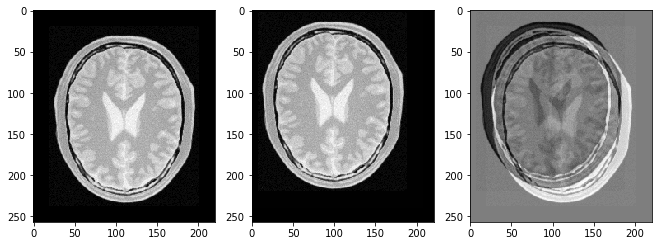

fixed image size    :  itkSize2 ([221, 257])
fixed image spacing :  itkVectorD2 ([1, 1])
fixed image origin  :  itkPointD2 ([0, 0])
moving image size    :  itkSize2 ([221, 257])
moving image spacing :  itkVectorD2 ([1, 1])
moving image origin  :  itkPointD2 ([0, 0])


In [20]:
#---------------------------------------------------------------
# genral paramaeters:
#---------------------------------------------------------------

swImage       = 0 # switch moving and fixed
useMSE        = 1  

#Optimiser parameters
numIterations =  100  
stepSize      =  15
accuracy      =  0.00001 
# translation transform parameters 
tx  = 13; 
ty  = 17; 
mu  = [tx,ty]


#---------------------------------------------------------------
# Input data 
#---------------------------------------------------------------
print("downloading data")
fixedFilename  = "BrainProtonDensitySliceBorder20.png"
fixedLink = "https://github.com/InsightSoftwareConsortium/ITK/raw/master/Examples/Data/BrainProtonDensitySliceBorder20.png"
urllib.request.urlretrieve (fixedLink, fixedFilename)

def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

def getMovingImage(fixed,mu,isMSE):
    #transform     
    imgA =imTransform(itk.GetArrayFromImage(fixed),mu)
    if not isMSE:
       #invert in case of mutual information 
       imgA = np.max(imgA)-imgA 
    movingImage = itk.GetImageFromArray(imgA)
    movingImage.CopyInformation(fixed)
    return movingImage

#  Reading the image using ITK

#define data types
dimension         = 2
PixelType         = itk.F
FixedImageType    = itk.Image[PixelType, dimension]
MovingImageType   = itk.Image[PixelType, dimension]

fixedImageReader  = itk.ImageFileReader[FixedImageType].New()
fixedImageReader.SetFileName(fixedFilename);   fixedImageReader.Update()
fixedImage        = fixedImageReader.GetOutput()
fixedImageRegion  = fixedImage.GetBufferedRegion()

#generate a moving image 

# to test the effect of multi-modality we invert the color 
isSame =   useMSE 
movingImage = getMovingImage(fixedImage,mu,isSame)

u  = itk.GetArrayFromImage(fixedImage)   
v  = itk.GetArrayFromImage(movingImage) 
print(u.shape)
print(v.shape)
f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
f.add_subplot(1,4, 1)
plt.imshow(u)
f.add_subplot(1,4, 2)
plt.imshow(v)
f.add_subplot(1,4, 3)
plt.imshow(u-v)
plt.show()


print("fixed image size    : ", fixedImage.GetLargestPossibleRegion().GetSize())
print("fixed image spacing : ", fixedImage.GetSpacing())
print("fixed image origin  : ", fixedImage.GetOrigin())

print("moving image size    : ", movingImage.GetLargestPossibleRegion().GetSize())
print("moving image spacing : ", movingImage.GetSpacing())
print("moving image origin  : ", movingImage.GetOrigin())


## Image registration

Image registtraion is the problem of finding parameters $\mu$ of a transformation $T(P,\mu)$ that aligns an image called the moving image $I_M(P)$ to another imaeg called the fixed image $I_F(P)$.

Finding these parameters is challenging. Optimisation e.g. gradient descent optimiser is used to find these parameters. The gradient descent tries to minimise a similarity metric $S(I_F,I_M)$by updating a transformation parameters.

$$\tag{1}
\mu = \mathrm{arg\,min}\quad S(I_F(P),I_M(T(P,\mu_{init}))
$$

where $\mu_{init}$ is the initial parameters.

 In this example the similarity metric is the mean squared error $S_{MSE}(I_F,I_M)$ which is defined as: 

$$\tag{2}
S_{MSE}(I_F(P),I_M(T(P,\mu)) =\frac{1}{n}\sum^{n-1}_{i=0}(I_F(p_i)-I_M(T(p_i,\mu)))^2
$$
where $n$ is the number of pixels in the image. 


The derivative of this mtric is :

$$\tag{3}
   \frac{\partial S_{MSE}(I_F(P),I_M(T(P,\mu))}{\partial \mu}=\frac{2}{n}\sum^{n-1}_{i=0}[\left(I_M(T(p_i,\mu)- I_F(p_i))\right)\left(\frac{-\partial I_M(T(p,\mu))}{\partial \mu}\right)] 
$$

Using chain rule:

$$\tag{4}
   \frac{\partial S_{MSE}}{\partial \mu}=\frac{2}{n}\sum^{n-1}_{i=0}[\left( I_M(T(p_i,\mu)-I_F(p_i))\right)\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}\frac{\partial (T(p_i,\mu))}{\partial \mu}]
$$

where:

* $\left( I_M(T(p_i,\mu)-I_F(p_i))\right)$ is constant during the optimisation
* $\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}$ is also constant during the optimisation. We compute the gradient of the moving image $dI_M=\frac{\partial I_M(p)}{\partial p}$ (one time operation before the optimisation). During the optiisation we get a transform point $\tilde p_i=T(p_i,\mu))$, then we get the intensity value $v$ from the moving image gradient at a transformed point location $v=dI_M(\tilde p)$. 
* $\frac{\partial (T(p_i,\mu))}{\partial \mu}$ is a row from $J_\mu$ that represent the current point.  $J_\mu$ is the Jacobian of the transformation with repect to its parameters. Note that $J_\mu$ is computed during each iteration of the optimisation:

$$\tag{5}
J_\mu = \frac{\partial T(P,\mu)}{\partial \mu}=\begin{pmatrix}
\frac{\partial T(p_1,\mu_1)}{\partial \mu_{1}}& \frac{\partial T(p_1,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_1,\mu_3)}{\partial \mu_{3}}  & . & . & . &  \frac{\partial T(p_1,\mu_m)}{\partial \mu_{m}} \\
\frac{\partial T(p_2,\mu_1)}{\partial \mu_{1}}   & \frac{\partial T(p_2,\mu_2)}{\partial \mu_{2}}   & \frac{\partial T(p_2,\mu_3)}{\partial \mu_{3}}  & . & . & . &  \frac{\partial x_{2}}{\partial \mu_{m}} \\ 
\frac{\partial x_{3}}{\partial p_{1}}   & \frac{\partial x_{3}}{\partial \mu_{2}}   & \frac{\partial x_{3}}{\partial \mu_{3}}  & . & . & . &  \frac{\partial x_{3}}{\partial \mu_{m}} \\ 
&  &  .&  &  &  & \\ 
 &  &  .&  &  &  & \\ 
 &  &  .&  &  &  & \\ 
 \frac{\partial x_{n}}{\partial \mu_{1}}   & \frac{\partial x_{n}}{\partial \mu_{2}}   & \frac{\partial x_{n}}{\partial \mu_{3}}  & . & . & . &  \frac{\partial x_{n}}{\partial \mu_{m}} \\ 
\end{pmatrix}
$$

Note that $J_\mu=\frac{\partial T(P,\mu)}{\partial \mu}$ is differnt from the Jacobian of the transformation $J=\frac{\partial T(P,\mu)}{\partial P}$ 

**Math Explaination:**

$\frac{\partial T(p_i,\mu_j)}{\partial \mu_{1}}$ means the derivative of the transformation $T$ qt point location $p$ with repect to the transform parameter $\mu_j$. Here is an example, assuming:

* a 2D point $p = (x,y)=(2,3)$
* a 2D translation transform $T(p,\mu) = T((x,y),(\mu_0,\mu_1)) = (x+\mu0,y+\mu_1)$
* we have :

$$
\frac{\partial T(p,\mu)}{\partial \mu}=\frac{\partial T((x,y),(\mu_0,\mu_1))}{\partial (\mu_0,\mu_1) }= \left(\frac{\partial (x+\mu0,y+\mu_1)}{\partial \mu_0},\frac{\partial (x+\mu0,y+\mu_1)}{\partial \mu_1}\right)=((1,0)(0,1))
$$

In this example we have :
$$
\frac{\partial T((2,3),\mu_0)}{\partial \mu_{0}}=(1,0) \\
\frac{\partial T((2,3),\mu_1)}{\partial \mu_{1}}=(0,1)
$$

which means the term:

$$
   \underbrace{(I_F(p_i)-I_M(T(p_i,\mu)))}_\text{scalar} \underbrace{\frac{\partial I_M(T(\tilde p,\mu))}{\partial \tilde p}}_\text{[dx,dy]}\underbrace{\frac{\partial (T(p_i,\mu))}{\partial \mu}}_\text{[[1,0],[0,1]]}=[d\mu0,d\mu_1] = [scalar * (dx *1 +dy*0) , scalar * (dx *0 +dy*1)  ] =[scalar*dx,scalar*dy]
$$

So it seems to update the parameters we just multiply the gradient of the transformed point with mean square error value. 



In [21]:
#tensor testing
# note, from the math above it seems we don't need them. 
x = np.array([[11,12,13],[21,22,23]])
y = np.array([[11,12,13],[21,22,23]]).transpose()
z= np.matmul(x,y)
print(z)
# xx = x[...,np.newaxis]
# yy = y[np.newaxis,...]
xx = x.reshape(2,3,1)
yy = x.reshape(3,2,1)
print(xx)
print(yy)
print(x.shape)
print(y.shape)
print(xx.shape)
print(yy.shape)
zz= np.tensordot(xx,yy,axes=([1,0],[0,1]))
print(zz[0][0])
print(zz.shape)



[[ 434  794]
 [ 794 1454]]
[[[11]
  [12]
  [13]]

 [[21]
  [22]
  [23]]]
[[[11]
  [12]]

 [[13]
  [21]]

 [[22]
  [23]]]
(2, 3)
(3, 2)
(2, 3, 1)
(3, 2, 1)
1806
(1, 1)


## ITK example 

Here I am using an ITK example to align the input fixed and moving images.   

0 : M: 0.445039   P: 0.000000 0.000000 
1 : M: 0.435718   P: -0.227749 -0.221534 
2 : M: 0.429337   P: -0.405936 -0.407667 
3 : M: 0.428494   P: -0.545905 -0.564431 
4 : M: 0.421562   P: -0.864346 -0.842767 
5 : M: 0.415116   P: -1.113332 -1.077216 
6 : M: 0.407827   P: -1.307462 -1.273789 
7 : M: 0.402810   P: -1.459246 -1.438825 
8 : M: 0.402699   P: -1.578369 -1.577655 
9 : M: 0.396858   P: -1.878145 -1.834627 
10 : M: 0.391449   P: -2.111893 -2.050744 
11 : M: 0.385018   P: -2.293660 -2.231669 
12 : M: 0.380602   P: -2.435365 -2.383297 
13 : M: 0.380744   P: -2.546232 -2.510600 
14 : M: 0.375397   P: -2.837530 -2.755470 
15 : M: 0.371721   P: -3.064266 -2.961329 
16 : M: 0.366120   P: -3.240233 -3.133491 
17 : M: 0.361955   P: -3.376865 -3.277397 
18 : M: 0.359044   P: -3.483348 -3.397895 
19 : M: 0.358622   P: -3.566594 -3.498913 
20 : M: 0.356902   P: -3.838912 -3.581069 
21 : M: 0.353498   P: -4.050563 -3.800056 
22 : M: 0.349657   P: -4.214867 -3.982788 
23 : M: 0.345613   P: -

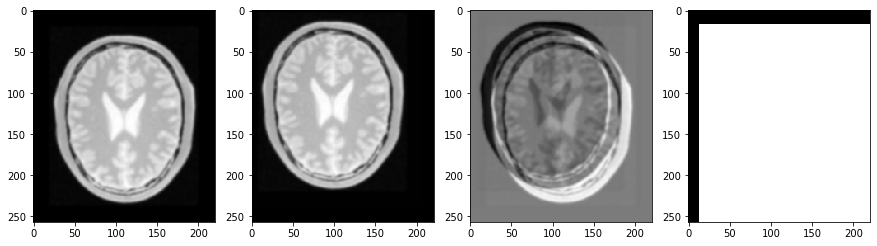

all tasks are done!.............


In [22]:
# This is an image registration code using ITK
InternalImageType = itk.Image[itk.F, dimension]

FixedNormalizeFilterType = itk.NormalizeImageFilter[FixedImageType, InternalImageType]
MovingNormalizeFilterType = itk.NormalizeImageFilter[MovingImageType, InternalImageType]
GaussianFilterType = itk.DiscreteGaussianImageFilter[InternalImageType, InternalImageType]

OptimizerType        = itk.GradientDescentOptimizer
RegistrationType     = itk.ImageRegistrationMethod[InternalImageType, InternalImageType]  
InterpolatorType     = itk.LinearInterpolateImageFunction[InternalImageType, itk.D]
TransformType        = itk.TranslationTransform[itk.D, dimension]

miMetricType     = itk.MutualInformationImageToImageMetric[InternalImageType, InternalImageType]
mseMetricType    = itk.MeanSquaresImageToImageMetric[InternalImageType, InternalImageType]


#Instantiate the classes 
fixedSmoother = GaussianFilterType.New()
movingSmoother = GaussianFilterType.New()
fixedNormalizer = FixedNormalizeFilterType.New()
movingNormalizer = MovingNormalizeFilterType.New()

transform    = TransformType.New()
optimizer    = OptimizerType.New()
interpolator = InterpolatorType.New()
registration = RegistrationType.New()
metricMI       = miMetricType.New()
metricMSE      = mseMetricType.New()

fixedSmoother = GaussianFilterType.New()
movingSmoother = GaussianFilterType.New()

#preprocessing
# normalization is important  
fixedNormalizer.SetInput(fixedImage)
movingNormalizer.SetInput(movingImage)
fixedNormalizer.Update()
fixedImageRegion = fixedNormalizer.GetOutput().GetBufferedRegion()
numberOfPixels = fixedImageRegion.GetNumberOfPixels()
numberOfSamples = int((numberOfPixels * 0.01))

if useMSE:
   metric =  metricMSE
else:
    metric = metricMI
    # For mutual information metric 
    metric.SetFixedImageStandardDeviation (0.4)
    metric.SetMovingImageStandardDeviation(0.4)
    metric.SetNumberOfSpatialSamples(numberOfSamples)
    metric.ReinitializeSeed(121212)

initialParameters = transform.GetParameters()
initialParameters[0] = 0.0 # Initial offset in mm along X
initialParameters[1] = 0.0 # Initial offset in mm along Y

# it seems smoothing is not important for mutual information
fixedSmoother.SetVariance(2.0)
movingSmoother.SetVariance(2.0)
fixedSmoother.SetInput(fixedNormalizer.GetOutput())
movingSmoother.SetInput(movingNormalizer.GetOutput())

# fixedImage  = fixedNormalizer.GetOutput()
# movingImage = movingNormalizer.GetOutput()

fixedImage  = fixedSmoother.GetOutput()
movingImage = movingSmoother.GetOutput()

u = itk.GetArrayFromImage(fixedImage)
v = itk.GetArrayFromImage(movingImage)

#image registration 
registration.SetOptimizer(optimizer)
registration.SetTransform(transform)
registration.SetInterpolator(interpolator)
registration.SetMetric(metric)
registration.SetFixedImage(fixedImage)
registration.SetMovingImage(movingImage)

# registration.SetFixedImage(fixedImage)
# registration.SetMovingImage(movingImage)

registration.SetFixedImageRegion(fixedImageRegion)
registration.SetInitialTransformParameters(initialParameters)


optimizer.SetLearningRate(stepSize)
optimizer.SetNumberOfIterations(numIterations)
if useMSE:
   optimizer.SetMinimize(True) 
else:
   optimizer.SetMaximize(True) 

#optimizer.MaximizeOn()

# Create the Command observer and register it with the optimizer.
def iterationUpdate():
    currentParameter = registration.GetOutput().Get().GetParameters()
    print( "%d : M: %f   P: %f %f " % (optimizer.GetCurrentIteration(), optimizer.GetValue(),  currentParameter.GetElement(0), currentParameter.GetElement(1)))
    if optimizer.GetValue()<accuracy:
       optimizer.StopOptimization()
observer = itk.PyCommand.New()
observer.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), observer)


registration.Update()
   

finalParameters = registration.GetLastTransformParameters()
TranslationAlongX = finalParameters[0]
TranslationAlongY = finalParameters[1]
numberOfIterations = optimizer.GetCurrentIteration()
bestValue = optimizer.GetValue()


# Print out results
print("Result = ")
print(" Translation X = " + str(TranslationAlongX))
print(" Translation Y = " + str(TranslationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))
print(" Numb. Samples = " + str(numberOfSamples))

ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]

finalTransform = TransformType.New()
finalTransform.SetParameters(finalParameters)
finalTransform.SetFixedParameters(transform.GetFixedParameters())

resample = ResampleFilterType.New()
resample.SetTransform(finalTransform)
resample.SetInput(movingImage)
resample.SetDefaultPixelValue(100)
resample.SetSize(fixedImage.GetLargestPossibleRegion().GetSize())
resample.SetOutputOrigin(fixedImage.GetOrigin())
resample.SetOutputSpacing(fixedImage.GetSpacing())
resample.SetOutputDirection(fixedImage.GetDirection())

registeredImage = resample.GetOutput()
r0 = itk.GetArrayFromImage(registeredImage)


# visualize the result 
print(u.shape)
print(v.shape)
f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
f.add_subplot(1,4, 1)
plt.imshow(u)
f.add_subplot(1,4, 2)
plt.imshow(v)
f.add_subplot(1,4, 3)
plt.imshow(u-v)
f.add_subplot(1,4, 4)
plt.imshow(u-r0)
plt.show()

# tx = TranslationAlongX; ty = TranslationAlongY
# r1 = imTransform( v , [tx,ty])
# plt.imshow(u-r1)
# plt.show()
# #u_normed = ( u - np.mean(u) ) /  np.std(u)

print("all tasks are done!.............")

## Simple Implementation

numIterations :  200
stepSize      :  15
0 :  0.44503942632313326  ,  [-0.30537447 -0.29528253]
1 :  0.43293756162297303  ,  [-0.60665707 -0.58588483]
2 :  0.43144860341435287  ,  [-0.82195429 -0.80042695]
3 :  0.42649699808088454  ,  [-1.03491569 -1.01056074]
4 :  0.4223129288848883  ,  [-1.24551108 -1.21604991]
5 :  0.4141625685555575  ,  [-1.45204452 -1.416226  ]
6 :  0.40752544423561105  ,  [-1.65472729 -1.61081945]
7 :  0.4099283963061429  ,  [-1.85407749 -1.79992032]
8 :  0.4060099386301213  ,  [-2.04995046 -1.98300124]
9 :  0.4025055446920612  ,  [-2.24211355 -2.16001838]
10 :  0.3958811782532528  ,  [-2.4289896  -2.33109204]
11 :  0.3903192235065232  ,  [-2.61088613 -2.49624764]
12 :  0.39000065474408857  ,  [-2.78814994 -2.65586567]
13 :  0.390132669584221  ,  [-2.96142124 -2.80968332]
14 :  0.3877342223180802  ,  [-3.13066157 -2.95778299]
15 :  0.38405479437734386  ,  [-3.29521131 -3.1009355 ]
16 :  0.3794457948923359  ,  [-3.45518344 -3.23999884]
17 :  0.37522121684463966  ,

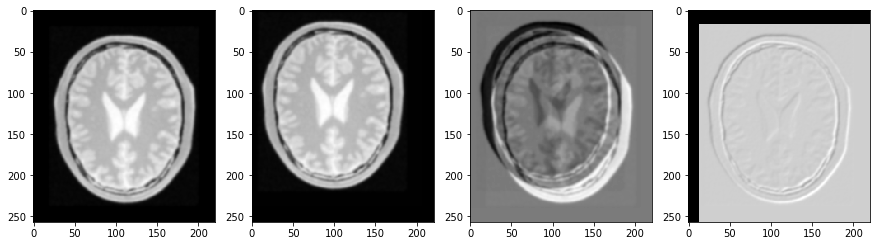

In [36]:
# Note, we will use the same preprocessed input images as in ITK
# TODO: use our implemnetation of:
# image gradient
# image interpolation

def mbNormalize(x):
   # normalize: nx will have a mean = 0 and std = 1
    nx = ( x - np.mean(x) ) /  np.std(x)
    return nx 

#mse metric
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

# get image gradient using ITK
def imGradient(img):
    f = itk.GetImageFromArray(img)
    df = itk.gradient_image_filter(f)
    g = itk.GetArrayFromImage(df)        
    return g

#mse derivative  
def mbdMSE(u,v,dT):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    dM = imGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4 
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0]) 
            dxy1 = np.dot([dx,dy],dT[:,1]) 
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0 
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension


# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    # initial parameters 
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        v_t = imTransform(v,nMu)
        tMshow = 0
        if tMshow:
            f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
            f.add_subplot(1,2, 1)
            plt.imshow(v_t)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # the second and the third term     
        dMu = mbdMSE(u,v_t,dT)        
        # update the parameters 
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)
    return nMu

print("numIterations : ", numIterations)
print("stepSize      : ", stepSize)   

numIterations = 200
stepSize      = 20

fMu =  gdOptimiser(u,v,numIterations,stepSize)

r0=imTransform(v,fMu)
f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
f.add_subplot(1,4, 1)
plt.imshow(u)
f.add_subplot(1,4, 2)
plt.imshow(v)
f.add_subplot(1,4, 3)
plt.imshow(u-v)
f.add_subplot(1,4, 4)
plt.imshow(u-r0)
plt.show()
